# Problem Set 3: Extra problems
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 17-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the corresponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Jacobsson, Simon**
- Personnummer: **970417-0456**
  <br/>
  (civic registration number)

## Problems
The 8 extra points of this problem set are distributed over two problems:
5. Bayesian Optimization (4 extra points)
6. Deep neural network python class (4 extra points)

# Problem 6: (extra) Deep neural network python class
### (4 extra points)
<!-- Author: -->  
Christian Forssén, Chalmers, and
Morten Hjorth-Jensen, University of Oslo and Michigan State University

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### latex stuff ###
use_tex = False

if use_tex:
    width = 5.5  # 5.5 for producing plot for report
    height = width/1.5
    fsize = 10  # fontsize, 10 for producing plot for report
    #font = {'family': 'serif', 'serif': ['DejaVu Sans'],'size': fsize}
    font = {'family': 'Times New Roman', 'size': fsize}
else:
    width = 6
    height = width/1.5
    fsize = 16
    font = {'size': fsize}
    
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=fsize)
mpl.rc('ytick', labelsize=fsize)
mpl.rc('text', usetex=use_tex)

## Developing a code for doing neural networks with back propagation

One can identify a set of key steps when using neural networks to solve supervised learning problems:  
  
1. Collect and pre-process data  
1. Define model and architecture  
1. Choose cost function and optimizer  
1. Train the model  
1. Adjust hyperparameters (if necessary, network architecture)
1. Evaluate model performance on test data  

### Collect and pre-process data

Here we will be using the MNIST dataset, which is readily available through the **scikit-learn**
package. You may also find it for example [here](http://yann.lecun.com/exdb/mnist/).  
The *MNIST* (Modified National Institute of Standards and Technology) database is a large database
of handwritten digits that is commonly used for training various image processing systems.  
The MNIST dataset consists of 70 000 images of size $28\times 28$ pixels, each labeled from 0 to 9.  
The scikit-learn dataset we will use consists of a selection of 1797 images of size $8\times 8$ collected and processed from this database.  

Since each input image is a 2D matrix, we need to flatten the image
(i.e. "unravel" the 2D matrix into a 1D array) to turn the data into a
design/feature matrix. This means we lose all spatial information in the
image, such as locality and translational invariance. More complicated
architectures such as Convolutional Neural Networks can take advantage
of such information, and are most commonly applied when analyzing
images.

inputs: (n_data, pixel_width, pixel_height) = (1797, 8, 8)
                       with labels (n_data) = (1797,)

flattened input, X: (n_inputs, n_features)  = (1797, 64)


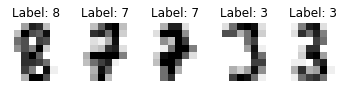

In [2]:
# import 
from sklearn import datasets

# ensure the same random numbers appear every time
np.random.seed(0)

# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

print(f"inputs: (n_data, pixel_width, pixel_height) = {inputs.shape}")
print(f"                       with labels (n_data) = {labels.shape}")


# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)
print(f"\nflattened input, X: (n_inputs, n_features)  = {inputs.shape}")


# choose some random images to display
indices = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {digits.target[random_indices[i]]:1}")

### Train and test datasets

We will reserve $70 \%$ of our dataset for training and $30 \%$ for testing. 

In [3]:
from sklearn.model_selection import train_test_split

# ensure the same random numbers appear every time
np.random.seed(0)

train_size = 0.7
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

print(f"Number of training images: {len(X_train):4}")
print(f"Number of test images:     {len(X_test):4}")

Number of training images: 1257
Number of test images:      540


In [4]:
# to categorical turns our integer vector into a onehot representation
# we implement it in in numpy
def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

### Task 1: Full object-oriented implementation

It is very natural to think of the network as an object, with specific instances of the network
being realizations of this object with different hyperparameters. An implementation using Python classes provides a clean structure and interface. 

The cost function should contain a $\lambda \sum_i \frac{1}{2} w_i^2$ regularizer. (*Note* that `lmbd` is used here for the decay width in the regularizer).

The skeleton for a Python class NeuralNetwork is implemented below. Specifically your tasks are to:
* Implement the `feed_forward` method of the `NeuralNetwork` class. It should update `self.z_h`, `self.a_h`, `self.z_o`, and `self.probabilities`.
* Correct the `backpropagation` method of the `NeuralNetwork` class. You must add the weight gradients from the regularizer term.
* Implement the `predict` method of the `NeuralNetwork` class. It should return the class label (integer).
* Implement the `predict_probabilities` method of the `NeuralNetwork` class. It should return the array of probabilities.

In [5]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def sigmoid(self, z):
        return 1./(1. + np.exp(-z))

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        self.z_h = self.X_data @ self.hidden_weights + self.hidden_bias

        self.a_h = self.sigmoid(self.z_h)
        self.z_L = self.a_h @ self.output_weights + self.output_bias
        self.probabilities = np.exp(self.z_L)

        ### normalize ###
        if (len(self.probabilities.shape) == 1): # if 1D array
            self.probabilities /= np.sum(self.probabilities)
        elif (len(self.probabilities.shape) == 2): # if 2D array
            for p in self.probabilities:
                p /= np.sum(p)
        else:
            raise Exception('input must be either 1D or 2D array')        
        

    def backpropagation(self):        
        error_output = self.probabilities - self.Y_data
        error_hidden = error_output @ self.output_weights.T * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = self.a_h.T @ error_output
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = self.X_data.T @ error_hidden
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        self.output_weights -= self.eta * (self.output_weights_gradient + self.lmbd * self.output_weights)
        self.output_bias -= self.eta * (self.output_bias_gradient + self.lmbd * self.output_bias)
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        self.X_data = X
        self.feed_forward()
        
        ### extract mode ###
        if (len(self.probabilities.shape) == 1): # if single array
            class_label = np.argmax(self.probabilities)
        elif (len(self.probabilities.shape) == 2): # if list of arrays
            class_label = np.argmax(self.probabilities, axis=1)
        else:
            raise Exception('input must be either 1D or 2D array')

        return class_label

    def predict_probabilities(self, X):
        self.X_data = X
        self.feed_forward()
        
        return self.probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()

### Task 2: Train and evaluate model performance on test data

We measure the performance of the network using the *accuracy* score. Initialize the neural network as specified below and:
* Measure the accuracy on the training data before training.
* Measure the accuracy on the training data after training.
* Measure the accuracy on the test data after training.

In [6]:
from sklearn.metrics import accuracy_score

epochs = 100
batch_size = 100

n_hidden_neurons = 50
n_categories = 10

eta=0.01
lmbd=0.1

# ensure the same random numbers appear every time
np.random.seed(0)

dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)

print(f"{epochs} epochs \n{batch_size} batches \n{n_hidden_neurons} hidden neurons \n{n_categories}\
 categories \neta = {eta} \nlambda = {lmbd}")
print(f"Accuracy on training data before training: {accuracy_score(dnn.predict(X_train), Y_train):.3f}")
dnn.train()
print(f"Accuracy on training data: {accuracy_score(dnn.predict(X_train), Y_train):.3f}")
print(f"Accuracy on test data: {accuracy_score(dnn.predict(X_test), Y_test):.3f}")

100 epochs 
100 batches 
50 hidden neurons 
10 categories 
eta = 0.01 
lambda = 0.1
Accuracy on training data before training: 0.046
Accuracy on training data: 0.994
Accuracy on test data: 0.941


### Task 3: Improving performance

As you might see the network does not seem to be learning at all. It seems to be just guessing the label for each image.  
In order to obtain a network that does something useful, we will have to tune the *hyperparameters* such as learning rate and regularization parameter. Those are hugely influential for the performance of the network. 

Typically a *grid-search* is performed, wherein we test different hyperparameters separated by orders of magnitude. For example we could test the learning rates $\eta = 10^{-5}, 10^{-4},...,10^{1}$ with different regularization parameters $\lambda = 10^{-5}, 10^{-4},,...,10^{1}$.  

If this does not improve network performance, you may want to consider altering the network architecture, adding more neurons or hidden layers.  
Andrew Ng goes through some of these considerations in this [video](https://youtu.be/F1ka6a13S9I). You can find a summary of the video [here](https://kevinzakka.github.io/2016/09/26/applying-deep-learning/).  


* Perform a grid search to find the optimal hyperparameters for the network. 
* What model gives you the best performance?
* What is the best accuracy on the test set?
Note that we are only using 1 layer with 50 neurons, and human performance is estimated to be around $98\%$ ($2\%$ error rate).

In [7]:
epochs = 100
batch_size = 100

n_hidden_neurons = 50
n_categories = 10

### define hyperparameter grids ###
etas = np.logspace(-5,1, 10)
lmbds = np.logspace(-3,3, 10)
eta_grid, lmbd_grid = np.meshgrid(etas, lmbds)
accuracies_train = np.full_like(eta_grid, np.nan) # initiate
accuracies_test = np.full_like(eta_grid, np.nan) # initiate

### loop over hyperparameter grids ###
for i, (eta, lmbd) in enumerate(zip(eta_grid.flatten(), lmbd_grid.flatten())):
    
    ### train network ###
    dnn = NeuralNetwork(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                    n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
    dnn.train()
    
    ### save accuracy ###
    index = np.unravel_index(i, accuracies_train.shape)
    accuracies_train[index] = accuracy_score(dnn.predict(X_train), Y_train)
    accuracies_test[index] = accuracy_score(dnn.predict(X_test), Y_test)
    

/home/simon/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
/home/simon/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
/home/simon/miniconda3/envs/tif285-env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


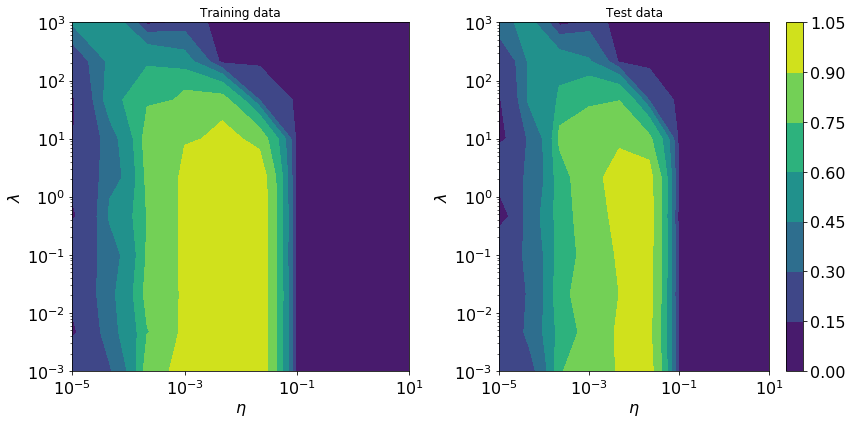

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
cs0 = ax[0].contourf(eta_grid, lmbd_grid, accuracies_train)
ax[0].set_title(r'Training data')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$\eta$', fontsize=fsize)
ax[0].set_ylabel(r'$\lambda$', fontsize=fsize)

cs1 = ax[1].contourf(eta_grid, lmbd_grid, accuracies_test)
ax[1].set_title(r'Test data')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\eta$', fontsize=fsize)
ax[1].set_ylabel(r'$\lambda$', fontsize=fsize)

fig.colorbar(cs1)
plt.tight_layout()
plt.show()